In [1]:
import sys
sys.path.append('..')

from common.utility import show_implementation
from module.utility import show_pyramids, show_images, array_is_equal
import numpy as np
from PIL import Image

In [2]:
rose_image = Image.open('images/rose.jpg').resize((288, 216))
rose_image_grey = np.array(rose_image.convert('L'))
words_image_grey = np.array(Image.open('images/words.jpg').resize((288, 216)).convert('L'))

face1_image_grey = np.array(Image.open('images/face1.jpg').resize((256, 256)).convert('L'))
face2_image_grey = np.array(Image.open('images/face2.jpg').resize((256, 256)).convert('L'))

# Filtering
## Motivation
Suppose that we have two photos taken at similar time interval of the same static object.
Notice that the digital image formed will not be exactly the same, due to noise in the sensors and minor differences in lighting conditions.
Thus, we would wish to remove noise from our images.

**Filtering**, in general terms, is the act of using information from a window of pixels in the image to derive a new pixel value in the resultant image.

## Types of noise
There are many types of noise, including

1. Salt and Pepper noise
    * Random occurrences of black and white pixels
    * Usually due to defects in the sensors.

2. Gaussian noise
    * Variation in intensity of each pixel drawn from a Gaussian distribution
    * Due to inherent noise of sensors and minute changes in lighting conditions.

In [3]:
from module.add_noise import salt_and_pepper, gaussian_noise
show_implementation(salt_and_pepper)
show_implementation(gaussian_noise)

def salt_and_pepper(img, prob=(0.02, 0.02)):
    img = np.array(img).astype(np.int16)
    
    mask = np.random.choice([-1, 0, 1], size=img.shape, p=[prob[0], 1-prob[0]-prob[1], prob[1]]).astype(np.int8)
    img = img + 255 * mask
    
    return np.clip(img, 0, 255)
def gaussian_noise(img, mu=0, sigma=20):
    img = np.array(img).astype(np.int16)
    mask = np.random.normal(mu, sigma, img.shape)
    img = img + mask
    
    return np.clip(img, 0, 255)


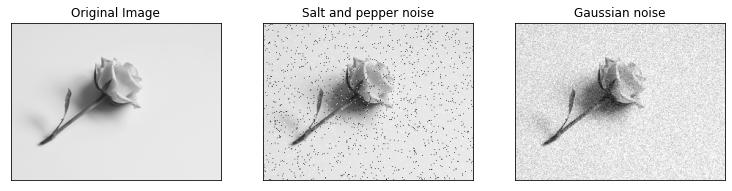

In [4]:
show_images([(rose_image_grey, 'Original Image'),
            (salt_and_pepper(rose_image_grey), 'Salt and pepper noise'),
            (gaussian_noise(rose_image_grey), 'Gaussian noise')
            ])

Suppose we plot the intensity plot around a noisy region.
We can make the assumption that noise correlate to the pixels whose intensity values are vastly different from its neighbours, like in the case of salt and pepper noise.
Thus, we can "smoothen" the image out by focusing on the average intensity values of the region in the image instead.

## Cross-correlation
We can generalize and formalize this, where given image with pixel values of $p_{i, j}$, a window of size $2k+1 \times 2k+1$ where the center pixel is $f_{0,0}$, the resultant image $x$ is 

$$
x_{i,j} = \sum ^k _{u = -k} \sum ^k _{v = -k} f_{u, v} p_{i + u, j+v}
$$

(This operation is called **cross-correlation**, denoted as $\vec X = \vec F\otimes \vec P$)

Thus, suppose we wish to average the pixels in a $3\times 3$ area, then it simply corresponds to using a filter which is a $3\times 3$ grid of $\frac{1}{9}$.
The "averaging" filter is also known as a **box filter**.

Notice that because each pixel in the new image corresponds to a region in the original, the new image is smaller than the original image.
We can either accept this as it is, or we could pad the original image on all sides before filtering, to maintain the size of the resultant image; at the cost of some artifacts at the borders of the new image.
Even though there exist more delicate ways to determine the values to pad to the image, for simplicity, we usually simply pad it with 0's or 255's.

In [5]:
from module.pad_image import paddable
show_implementation(paddable)

def paddable(func):
    @wraps(func)
    def inner(img, window, pad=True, value=255, **kwargs):
        if pad:    
            img = pad_image(img, window, value)
        return func(img, window, **kwargs)

    return inner


In [6]:
from module.correlate import naive_correlate
show_implementation(naive_correlate.__wrapped__)

@paddable
def naive_correlate(img, window, clip=True):
    assert len(window.shape) == 2
    
    wh, ww = window.shape
    height, width = img.shape
    new_image = np.zeros((height - wh + 1, width - ww + 1))
    
    for i in range(0, height - wh + 1):
        for j in range(0, width - ww + 1):
            new_image[i][j] = (window * img[i:i+wh, j:j+ww]).sum()
    if clip:
        new_image = np.clip(new_image, 0, 255)
    return new_image


In [7]:
from module.kernel import box_filter
show_implementation(box_filter)

def box_filter(size):
    return np.ones((size, size))/size**2


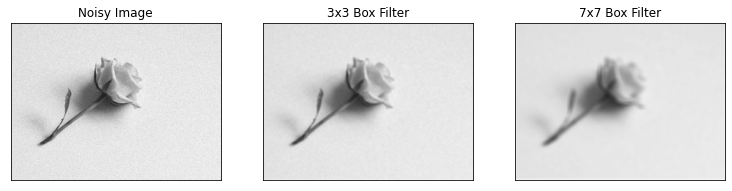

In [8]:
noisy_image = gaussian_noise(rose_image_grey, sigma=5)

show_images([(noisy_image, 'Noisy Image'),
            (naive_correlate(noisy_image, box_filter(3)), '3x3 Box Filter'),
            (naive_correlate(noisy_image, box_filter(7)), '7x7 Box Filter')
            ])

Notice that after filtering, the noise becomes less pronounced.
However, using a large window will blur the image.

### Optimization

To further optimize the correlation process, we can pre-extract all the window regions which will be used for each kernel location, and multiply it with the raveled kernel.
This speeds up performance by separating the value extraction from the loop and by reducing the dimension (the new kernel is 1 dimensional) that the multiplication and summation to work across.

In [9]:
from module.correlate import correlate
show_implementation(correlate.__wrapped__)

@paddable
def correlate(img, window, clip=True):
    assert len(window.shape) == 2
    wh, ww = window.shape
    height, width = img.shape
    new_height, new_width = height - wh + 1, width - ww + 1

    extracted_regions = np.zeros((new_height * new_width, wh * ww))

    for i in range(new_height):
        for j in range(new_width):
            extracted_regions[i * new_width + j] = img[i: i + wh, j: j + ww].ravel()

    products = extracted_regions * window.ravel()
    result = products.sum(axis=1).reshape((new_height, new_width))
    return result


In [10]:
%timeit -n 10 naive_correlate(noisy_image, box_filter(7))
%timeit -n 10 correlate(noisy_image, box_filter(7))

220 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
88 ms ± 4.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Gaussian Kernel

We can use a higher weight for the pixels that are closer to the center of the window, so that the resultant pixel intensity will be closer to that of the original pixel.
One easy filter to use is the Gaussian filter, where the center pixel has the value of 1, and the other pixel have smaller value the further it is from the center, as in a Gaussian function.
$\sigma$ controls how large the Gaussian kernel is, thus controlling the amount of smoothing.


In [10]:
from module.kernel import gaussian_filter
show_implementation(gaussian_filter)

def gaussian_filter(size, sigma=1):
    assert size % 2 == 1
    
    kernel = np.ones((size, size), np.float64)
    k = size // 2
    for i in range(size):
        for j in range(size):
            exponent = -((i - k)**2 + (j-k)**2) / (2 * sigma**2) 
            kernel[i][j] = np.exp(exponent)/ (2 * np.pi*sigma**2)
    return kernel


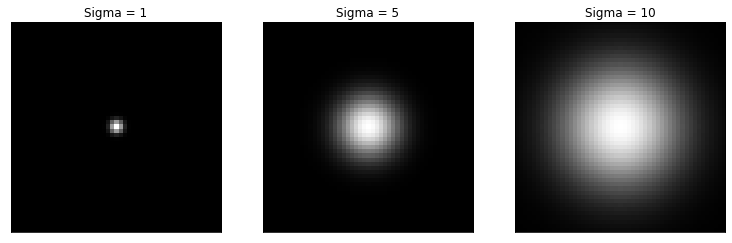

In [11]:
noisy_image = gaussian_noise(rose_image_grey, sigma=5)

show_images([(gaussian_filter(51, 1), "Sigma = 1", True),
            (gaussian_filter(51, 5), "Sigma = 5", True),
            (gaussian_filter(51, 10), "Sigma = 10", True)])

(Note that we scaled intensity values of the kernels with the larger sigmas, otherwise it will not be visible. Thus in actuality, the kernel with sigma=10 brightness spot is not equally as bright as that of sigma=1)

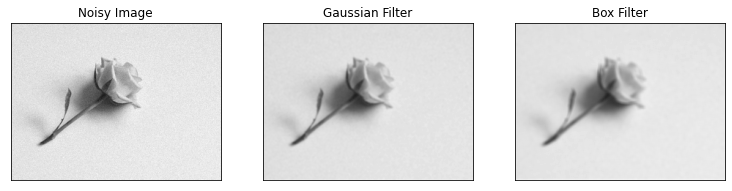

In [12]:
show_images([(noisy_image, 'Noisy Image'),
            (correlate(noisy_image, window=gaussian_filter(5, 1)), 'Gaussian Filter'),
            (correlate(noisy_image, window=box_filter(5)), 'Box Filter')
            ])

Note that the Gaussian filter perform better than the box filter as it removes the noise better while not blurring as much.

## Kernels as Transformations


Suppose that we used a kernel as below

$$
f = 
\begin{pmatrix}
0 & 0 & 0 \\
0 & 0 & 1 \\
0 & 0 & 0
\end{pmatrix}
$$

What would the resulting image be?

Since each pixel coordinate in the new image takes the value of the pixel to the right of it, this means that the resultant image will be shifted to the left.

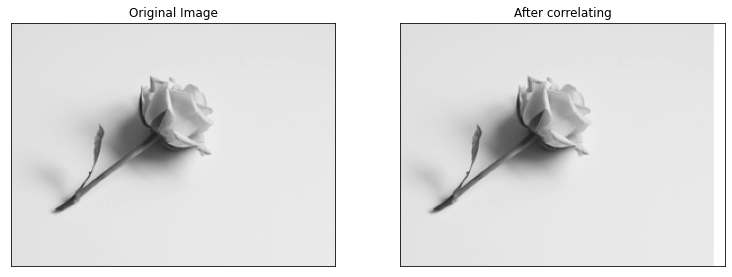

In [13]:
kernel = np.zeros((21, 21))
kernel[10][20] = 1

show_images([(rose_image_grey, 'Original Image'),
            (correlate(rose_image_grey, window=kernel), 'After correlating'),
            ])

(We used a 21x21 kernel instead to exaggerate the effects)

This tells us that we can do some transformation operations using correlation on the appropriate kernels.

What about the kernel below?


$$
f = 
\begin{pmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0
\end{pmatrix}
$$

It is clear that the resulting image will be identical to the original image.

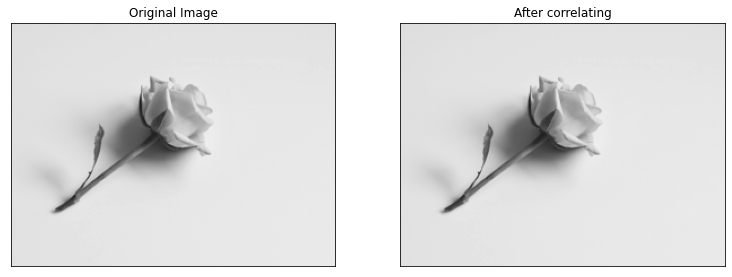

In [14]:
identity_kernel = np.zeros((3, 3))
identity_kernel[1][1] = 1

show_images([(rose_image_grey, 'Original Image'),
            (correlate(rose_image_grey, window=identity_kernel), 'After correlating'),
            ])

## Sharpening
Suppose we apply correlation using the below kernel

$$
f = 
\begin{pmatrix}
-1/9 & -1/9 & -1/9\\
-1/9 & 17/9 & -1/9\\
-1/9 & -1/9 & -1/9\\
\end{pmatrix}
$$

Notice that this kernel can be decomposed as below
$$
f = 
\begin{pmatrix}
-1/9 & -1/9 & -1/9\\
-1/9 & 17/9 & -1/9\\
-1/9 & -1/9 & -1/9\\
\end{pmatrix}
= 
\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1\\
\end{pmatrix}
+
\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1\\
\end{pmatrix}
-
\begin{pmatrix}
1/9 & 1/9 & 1/9\\
1/9 & 1/9 & 1/9\\
1/9 & 1/9 & 1/9\\
\end{pmatrix}
= 
\underbrace{
\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1\\
\end{pmatrix}}_{A}
+
\underbrace{
\left(
\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1\\
\end{pmatrix}
-
\begin{pmatrix}
1/9 & 1/9 & 1/9\\
1/9 & 1/9 & 1/9\\
1/9 & 1/9 & 1/9\\
\end{pmatrix}
\right)}_{B}
$$

$A$ is just the image itself.
$B$ is the image subtracted with the box filter blur of the time, which corresponds to how different each pixel value is from its neighbours.

What would the result be if we correlate using it?

Notice since we add the regions which are different from the neighbours this will emphasise the differences between each pixel, thus sharpening the image.

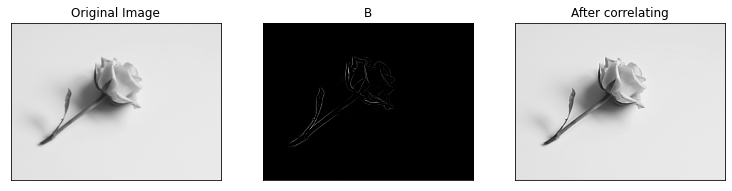

In [15]:
local_diff_kernel = -np.ones((3, 3)) / 9
local_diff_kernel[1][1] = 8/9

sharpen_kernel = -np.ones((3, 3)) / 9
sharpen_kernel[1][1] = 17/9

show_images([(rose_image_grey, 'Original Image'),
            (correlate(rose_image_grey, window=local_diff_kernel), 'B', True),
            (correlate(rose_image_grey, window=sharpen_kernel), 'After correlating'),
            ])

In [16]:
from module.point_process import adjust_contrast

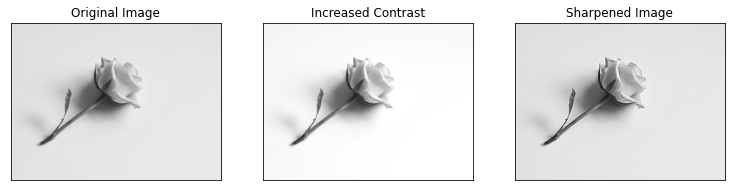

In [17]:
show_images([(rose_image_grey, 'Original Image'),
            (adjust_contrast(rose_image_grey, 1.1), 'Increased Contrast'),
            (correlate(rose_image_grey, window=sharpen_kernel), 'Sharpened Image'),
            ])

Notice that unlike increasing contrast, sharpening will have little to no effect on areas in the image where the pixel values are similar; increasing contrast will scale all the pixel intensity by the same amount instead, making them brighter.

Thus, sharpening will emphasise the intensity peaks and differences compared to the surrounding pixels.

Consider the below situation, where we apply sharpening each image matrix below

* Flat region
    * There is no change
* Region with edge
    * Edge gets emphasised
* Flat region with noise
    * Noise is also emphasised

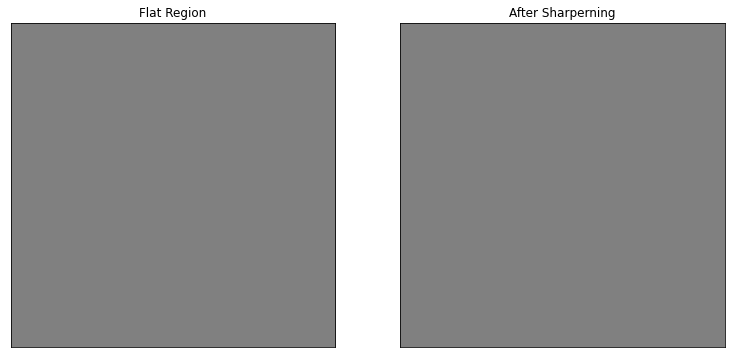

In [18]:
flat_region = np.ones((11, 11)) * 128
correlate(flat_region, window=sharpen_kernel)

show_images([(flat_region, "Flat Region"),
             (correlate(flat_region, window=sharpen_kernel, pad=False), "After Sharperning")])

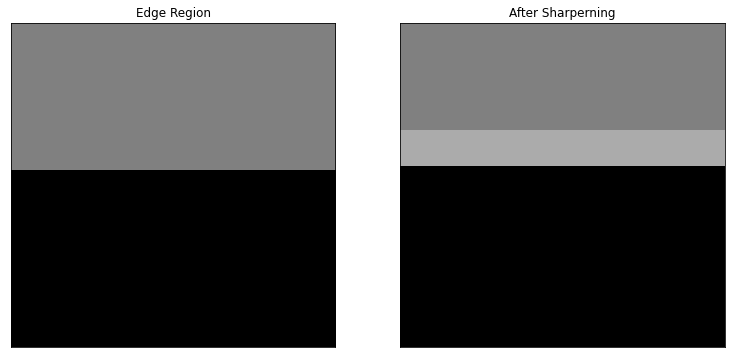

In [19]:
edge_region = np.vstack([np.ones((5, 11)) * 128, np.zeros((6, 11))])
show_images([(edge_region, "Edge Region"),
             (correlate(edge_region, window=sharpen_kernel, pad=False), "After Sharperning")])

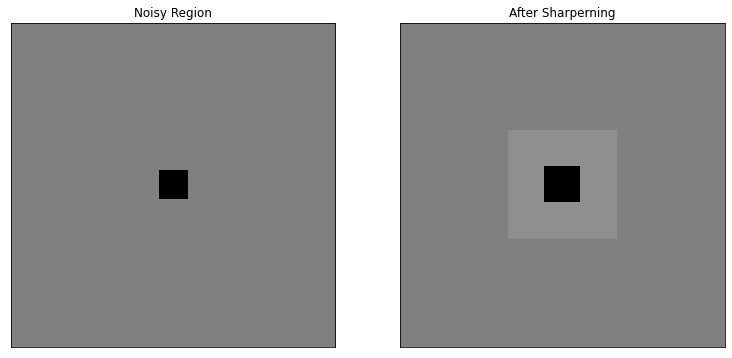

In [20]:
flat_region_with_noise = np.ones((11, 11)) * 128 
flat_region_with_noise[5][5] = 0
show_images([(flat_region_with_noise, "Noisy Region"),
             (correlate(flat_region_with_noise, window=sharpen_kernel, pad=False), "After Sharperning")])

## Template matching
Suppose that we have a region of pixels that we wish to find.
This region is called the "template".
Using normalized cross-correlation, it is possible to identify the region where the template matches.

Suppose we have the below image and template.

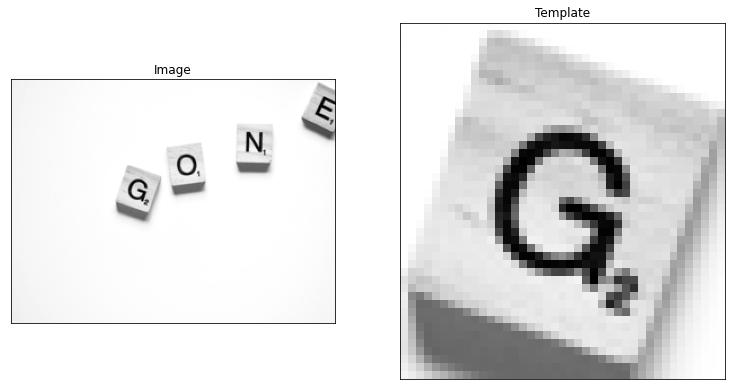

In [21]:
template = words_image_grey[75:120, 92:133].astype("float64")
show_images([(words_image_grey, "Image"), (template, "Template")])

Suppose we cross-correlate the image with the template.
We would expect the region where the template appears to have high intensity, because those region will have the same pixel values squared after correlating.

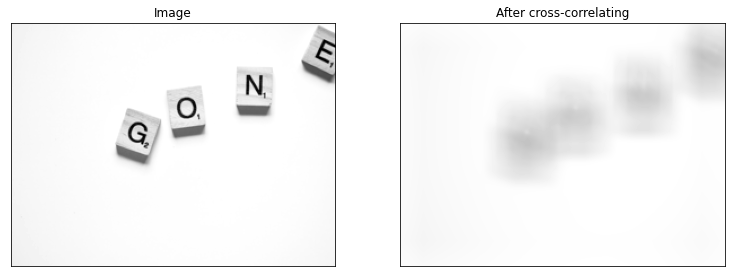

In [22]:
show_images([(words_image_grey, "Image"), 
             (correlate(words_image_grey, template, clip=False), "After cross-correlating", True)])

However, notice that the resultant image has high intensity for the white background regions also.
This is because they have a value of $255 \times f$, while the region with the template has values $f \times f$.
Thus, the response from the white regions will have higher response than the template.

To overcome this, we can divide the response by the sum of intensities in the pixel region.
This normalizes the response, thus regions with white areas will not give a stronger response than the template region.
For those with a background in linear algebra, this is similar to finding two vectors that are in similar directions to each other by finding their normalized dot products.

Thus, our response is defined as
$$
\vec{X} = \frac{1}{|\vec{F}||\vec{w_{i,j}}|} \vec F \otimes \vec P
$$,

where $|\vec{w_{i,j}}|$ is the magnitude the intensity in the pixel region.

We also divide by the magnitude of the template to clamp the values between 0 and 1.

This process is called **normalized cross-correlation**.

In [23]:
from module.correlate import normalized_correlate
show_implementation(normalized_correlate)

@paddable
def normalized_correlate(img, template):
    pixel_sums = np.sqrt(correlate(img.astype("float64") ** 2, np.ones(template.shape), clip=False, pad=False))
    template_mag = np.sqrt((template**2).sum())

    return correlate(img, template, pad=False)/pixel_sums/template_mag


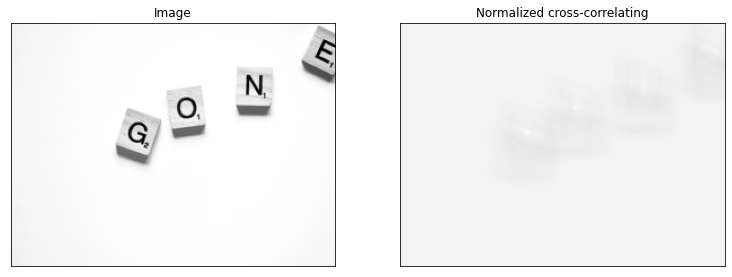

In [24]:
result = normalized_correlate(words_image_grey, template)
show_images([(words_image_grey, "Image"), 
             (result, "Normalized cross-correlating", True)])

As we can see, this produces much better results than simply cross-correlating.
To see the results better, we can mask out only the pixels with the highest value in the response.

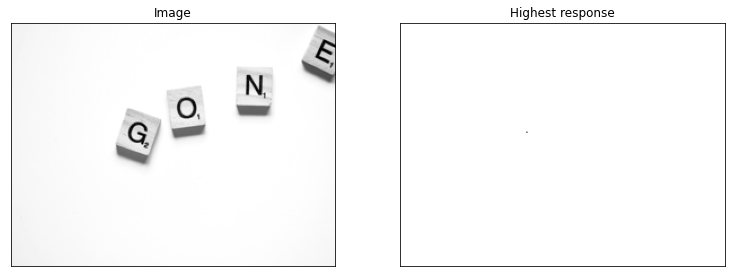

In [25]:
masked = np.where(result == result.max(), 0, 1)
show_images([(words_image_grey, "Image"), 
             (masked, "Highest response", True)])

Indeed, we only find candidate location for the best match for the template.

### Limitations
Template matching is sensitive to differences in the desired template and the region in the image.
Suppose that the template is in a different orientation or size in the image, or the object is occluded in the image, then template matching will fail to capture the desired region.

For example below, we use a slightly smaller template than in the image.

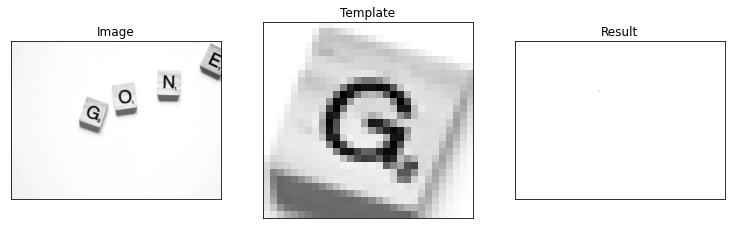

In [26]:
resized_template = Image.fromarray(template).resize((30, 28))
resized_template = np.array(resized_template)
result = normalized_correlate(words_image_grey, resized_template)
masked = np.where(result == result.max(), 0, 1)
show_images([(words_image_grey, "Image"), 
             (resized_template, "Template"), 
             (masked, "Result", True)])

Notice that normalized cross-correlation is now unable to detect the correct region.

## Convolution

Suppose we cross-correlate a impulse signal $P$ with the kernel $F$
$$
X = 
\begin{pmatrix}
\ddots &\vdots &\vdots &\vdots &\vdots\\
\cdots & 0 & 0 & 0 & \cdots \\
\cdots & 0 & 1 & 0 & \cdots \\
\cdots & 0 & 0 & 0 & \cdots \\
\vdots &\vdots &\vdots &\vdots &\ddots\\
\end{pmatrix}
\otimes
\begin{pmatrix}
1 & 2 & 3\\
4 & 5 & 6\\
7 & 8 & 9\\
\end{pmatrix}
= \begin{pmatrix}
\ddots &\vdots &\vdots &\vdots &\vdots\\
\cdots & 9 & 8 & 7 & \cdots \\
\cdots & 6 & 5 & 4 & \cdots \\
\cdots & 3 & 2 & 1 & \cdots \\
\vdots &\vdots &\vdots &\vdots &\ddots
\end{pmatrix}
$$

Notice that the resultant image is not identical to the kernel, even though the image itself is an impulse signal.

Suppose that we flipped the kernel before applying the cross-correlation.
Notice that now, the resultant image will be the same as the kernel.

From here, notice that this operation is equivalent to
$$
x_{i,j} = \sum ^k _{u = -k} \sum ^k _{v = -k} f_{u, v} p_{i - u, j - v}
$$

, where we subtract the indices instead.

This operation is called **convolution**, denoted as $\vec X = \vec F * \vec P$.

There are a few desirable properties that exists in convolution, compared to cross-correlation.

|Property| Example|Convolution|Cross-correlation|
|:------:|:------:|:---------:|:---------------:|
|Commutative     |$$f * g = g * f$$                                            | ✓ | 𐄂|
|Associative     |$$(f * g) * h = f * (g * h)$$                                | ✓ | 𐄂|
|Distributive    |$$f * (g + h) = f * g + f * h$$                              | ✓ | ✓|
|Scalar Factoring|$$\lambda (f * g) = (\lambda f) * g = f * (\lambda g)$$      | ✓ | ✓|
|Identity        |$$f * e = f, \text{for some } e = [\cdots, 0, 1, 0, \cdots]$$| ✓ | 𐄂|

Because of the above properties, it is standard to refer to convolution when we talk about filtering.

However, since many kernels that we use are symmetric, it is often that both terms are interchangeable in discussions.

In [27]:
from module.convolve import convolve
show_implementation(convolve.__wrapped__)

@paddable
def convolve(img, window, clip=True):
    return correlate(img, np.flip(window), clip=clip, pad=False)


For example, because of the associative property of convolution, if we wish to apply multiple filters to an image, we can convolve all the filters together, before convolving the result to the image.
This requires less computational time than convolving the filter to the image sequentially (assuming the kernel is smaller than the image).

## Non-linear filters
### Median Filter

In [28]:
from module.median_filter import median_filter
show_implementation(median_filter.__wrapped__)

@paddable
def median_filter(img, window_shape):
    assert len(window_shape) == 2
    
    wh, ww = window_shape
    height, width = img.shape
    new_image = np.zeros((height - wh + 1, width - ww + 1))
    
    for i in range(0, height - wh + 1):
        for j in range(0, width - ww + 1):
            new_image[i][j] = np.median(img[i:i+wh, j:j+ww])
    return new_image


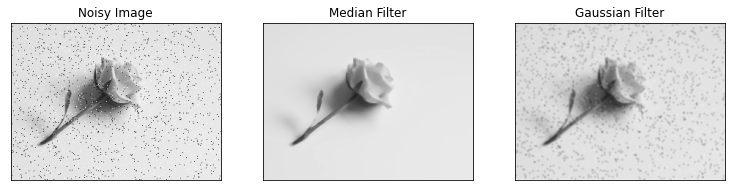

In [29]:
noisy_image = salt_and_pepper(rose_image_grey)
show_images([(noisy_image, "Noisy Image"), 
             (median_filter(noisy_image, (5, 5)), "Median Filter"),
            (correlate(noisy_image, window=gaussian_filter(5, 1)), "Gaussian Filter")])

As we can see, for salt and pepper noise, median filtering performs much better than Gaussian filtering because it removes the noise instead of blurring it into the image.

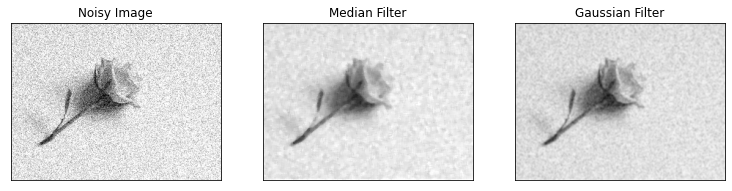

In [30]:
noisy_image = gaussian_noise(rose_image_grey, sigma=30)
show_images([(noisy_image, "Noisy Image"), 
             (median_filter(noisy_image, (5, 5)), "Median Filter"),
            (correlate(noisy_image, window=gaussian_filter(5, 1)), "Gaussian Filter")])

For Gaussian noise, there is no noticeable performance benefit to using median filters over Gaussian filters.

However, it is to note that since median filtering is non-linear, it is much more computationally expensive.

In [32]:
%timeit -n 10 median_filter(noisy_image, (5,5))
%timeit -n 10 correlate(noisy_image, gaussian_filter(5, 1))

1.94 s ± 69.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
80.1 ms ± 724 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Image Pyramid

Suppose that we wish to resize an image.

## Naive Downsampling
A straight forward approach is to discard every $n$ pixel in the image to obtain a smaller image.

In [31]:
from module.resize import downsample
show_implementation(downsample)

def downsample(img, factor=2):
    h, w = img.shape
    new_image = np.zeros((h // factor, w // factor))
    
    for i in range(h // factor):
        for j in range(w // factor):
            new_image[i][j] = img[i * factor][j * factor]
    return img[::factor,::factor]


In [32]:
rose_image = Image.open('images/rose.jpg').resize((864, 648))
rose_image_grey = np.array(rose_image.convert('L'))

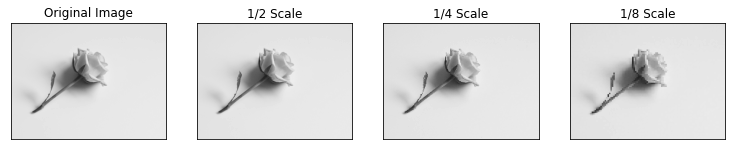

In [33]:
downsample_arr = [(rose_image_grey, "Original Image")]

for i in range(3):
    downsample_arr.append((downsample(downsample_arr[-1][0]), f"1/{2**(i+1)} Scale"))

show_images(downsample_arr)

However, notice that repeated downsampling results in pixelation effects.

## Gaussian Pyramid
Suppose instead, that we blur before we downsample.
This can help reduce the pixelation effect from repeated downsampling.

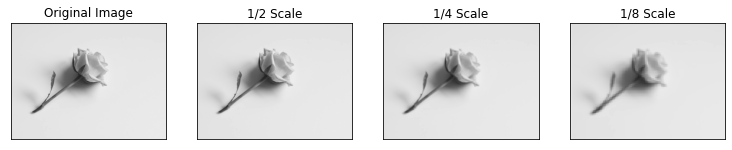

In [34]:
blur_downsample = lambda x: downsample(convolve(x, gaussian_filter(7, sigma=1)), 2)

downsample_with_blur_arr = [(rose_image_grey, "Original Image")]

for i in range(3):
    downsample_with_blur_arr.append((blur_downsample(downsample_with_blur_arr[-1][0]), f"1/{2**(i+1)} Scale"))

show_images(downsample_with_blur_arr)

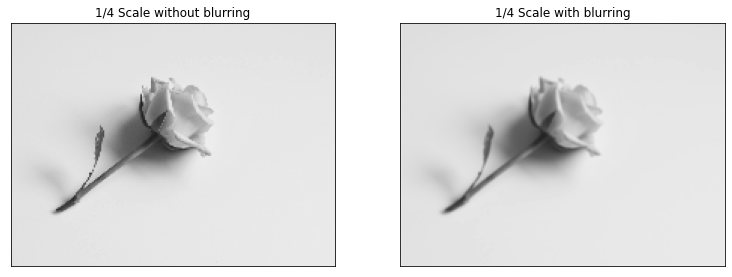

In [35]:
show_images([(downsample_arr[2][0], "1/4 Scale without blurring"),
             (downsample_with_blur_arr[2][0], "1/4 Scale with blurring")])

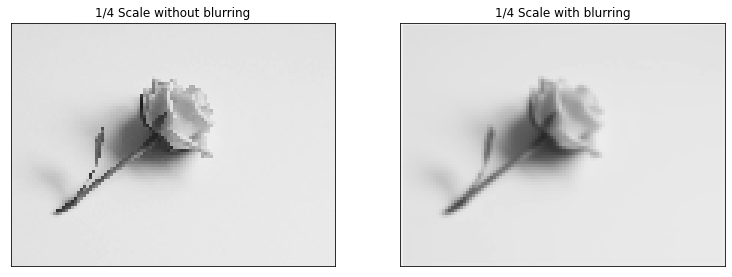

In [36]:
show_images([(downsample_arr[3][0], "1/4 Scale without blurring"),
             (downsample_with_blur_arr[3][0], "1/4 Scale with blurring")])

This sequence of images which are repeated downsampled with blurring is called the **Gaussian pyramid**

In [37]:
from module.pyramid import make_gaussian_pyramid
show_implementation(make_gaussian_pyramid)

def make_gaussian_pyramid(image, levels, kernel=default_kernel):
    blur_downsample = lambda x: downsample(convolve(x, kernel))

    arr = [image]

    for _ in range(levels - 1):
        arr.append(blur_downsample(arr[-1]))

    return arr


In [38]:
gaussian_pyramid = make_gaussian_pyramid(rose_image_grey, 4)

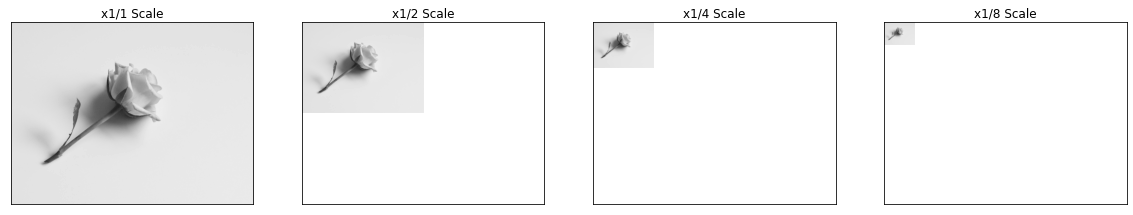

In [39]:
show_pyramids(gaussian_pyramid, "x1/{} Scale", format_func=lambda level: 2 ** (level-1))

In [40]:
list(map(lambda x: x.shape, gaussian_pyramid))

[(648, 864), (324, 432), (162, 216), (81, 108)]

Using the Gaussian pyramid, we can continually shrink our image until we reach our desired minimal resolution.
After each step, details are smoothed out by the blurring steps.

Because data is loss during the downsampling and the blurring stages, this sequence of processing is lossy, therefore we are unable to reproduce our original image.

In [41]:
from module.resize import upsample
show_implementation(upsample)

def upsample(img, factor=2):
    return img.repeat(factor, axis=1).repeat(factor, axis=0)


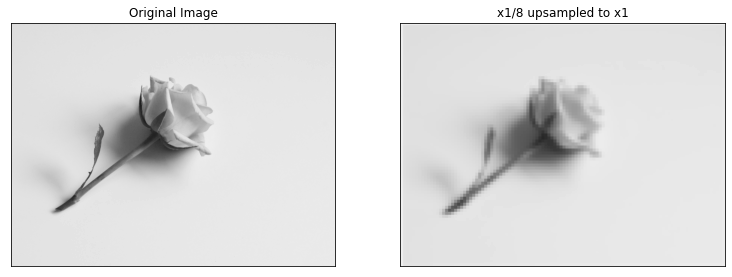

In [42]:
show_images([(gaussian_pyramid[0], "Original Image"),
             (upsample(gaussian_pyramid[3], 8), "x1/8 upsampled to x1")])

As we can see, when we upsample using the smaller image, we cannot determine the pixel values that were lost during downsampling, thus the image appears pixelated because there are large blocks of pixels with the same value.

## Laplacian Pyramid
Suppose we have an image and the image at x1/2 scale.
Suppose we do the following:
1. Upsample the 1/2 scale image to get an image with the same size as the original image.
2. Blur the upsampled image.
3. Find the difference (known as the **residual**) between the image and the upscaled image.

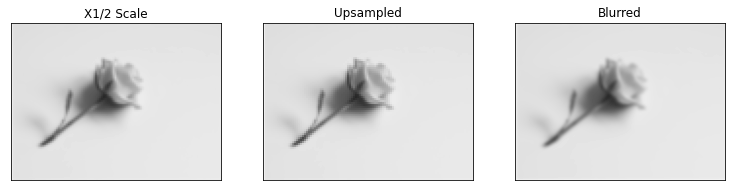

In [43]:
upsampled = upsample(gaussian_pyramid[3])
kernel = gaussian_filter(7, sigma=1)
blurred = convolve(upsampled, kernel)
diff = gaussian_pyramid[2] - blurred
show_images([(gaussian_pyramid[3], "X1/2 Scale"),
             (upsampled, "Upsampled"),
             (blurred, "Blurred")])

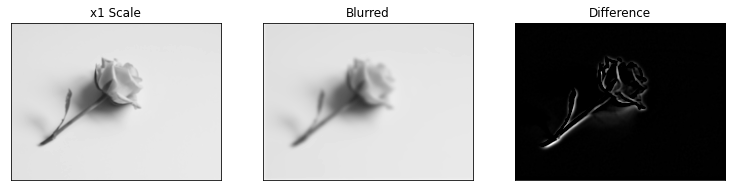

In [44]:
show_images([(gaussian_pyramid[2], "x1 Scale"),
             (blurred, "Blurred"),
             (diff, "Difference", True)])

Suppose that, somehow, we have access to this difference between the two images and the downsampled image.
Then we could easily reproduce the original image by upsampling the downsampled image and adding the difference.

In [45]:
array_is_equal(convolve(upsample(gaussian_pyramid[3]),kernel) + diff, gaussian_pyramid[2])

True

With this in mind, we can store the smallest image in the Gaussian pyramid together with the differences between the "post-processed" image at each level.
This sequence of images is called the **Laplacian pyramid**.



Because we can obtain a image of a higher scale in the Gaussian pyramid when given an image of a lower scale from the Gaussian pyramid and the corresponding residual, it is possible for us to recover the original image with this setup.

In [46]:
from module.pyramid import make_laplacian_pyramid
show_implementation(make_laplacian_pyramid)

def make_laplacian_pyramid(image, levels, kernel=default_kernel):
    gaussian_pyramid = make_gaussian_pyramid(image, levels, kernel)
    flipped_pyramid = list(reversed(gaussian_pyramid))
    arr = [flipped_pyramid[0]]

    for image, next_image in zip(flipped_pyramid, flipped_pyramid[1:]):
        upsampled = upsample(image)
        blurred = convolve(upsampled, kernel)
        diff = next_image - blurred
        arr.append(diff)
        
    return arr[::-1]


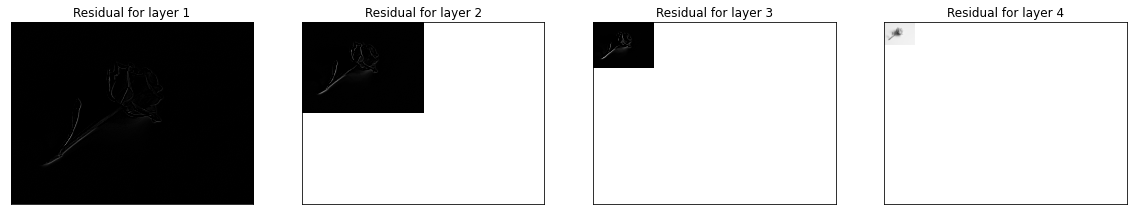

In [47]:
laplacian_pyramid = make_laplacian_pyramid(rose_image_grey, 4)
show_pyramids(laplacian_pyramid, "Residual for layer {}", autoscale=True)

In [48]:
from module.pyramid import combine, recover
show_implementation(combine)
show_implementation(recover)

def combine(img, residual, kernel=default_kernel):
    upsampled = upsample(img)
    blurred = convolve(upsampled, kernel)
    return blurred + residual
def recover(laplacian_pyramid, kernel=default_kernel):
    recovered_images = [laplacian_pyramid[-1]]

    for residual in reversed(laplacian_pyramid[:-1]):
        recovered_images.append(combine(recovered_images[-1], residual, kernel))
    return recovered_images


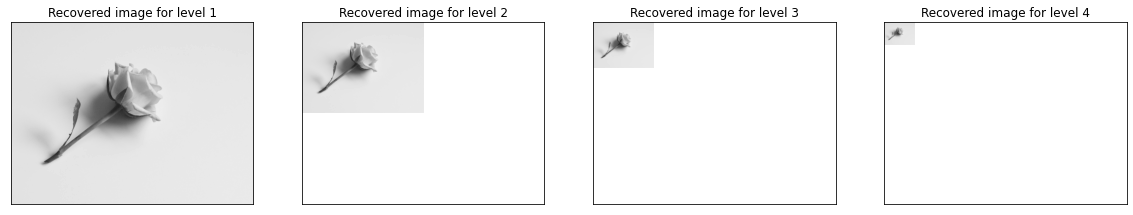

In [49]:
recovered_images = recover(laplacian_pyramid)
show_pyramids(recovered_images[::-1], "Recovered image for level {}")

The above are our recovered image by continually combining the image with its residual.

In [50]:
array_is_equal(rose_image_grey, recovered_images[-1])

True

And we can see indeed, that the original image is recovered.

## Uses of Image Pyramids

### Compression
Notice that in a Laplacian pyramid, the residuals are very "flat", thus are great candidates for compression algorithms.
This allows us to store the original image as a series of easily compressible residuals, and 1 small resolution image.

### Image Blending

Suppose we have 2 images that we wish to blend together as per below.

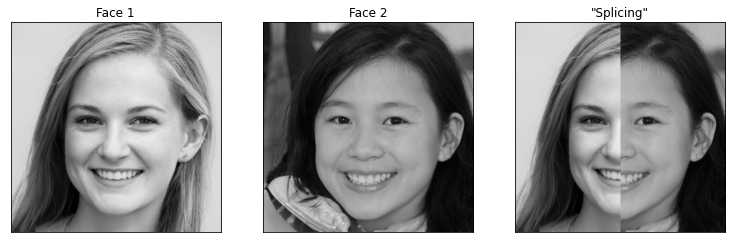

In [51]:
show_images([(face1_image_grey, "Face 1"), 
             (face2_image_grey, "Face 2"), 
             (np.hstack((face1_image_grey[:,:128], face2_image_grey[:,128:])), '"Splicing"')])

(Images generated from https://thispersondoesnotexist.com/)

Just splicing the two images together yields rather unsatisfactory results, because there is a harsh divide line between the two halves.

We can use the image pyramid to obtain (somewhat) better results.

Firstly, we decide on the kernel and the mask that we wish to use.
We use a larger kernel for more blending effect.

The mask simply tells us which image we should use for each region in the image.
For example, 255 will tell us to use the the first face, and 0 will tell us to use the 2nd.
Any number in between will be a mixture of the two.

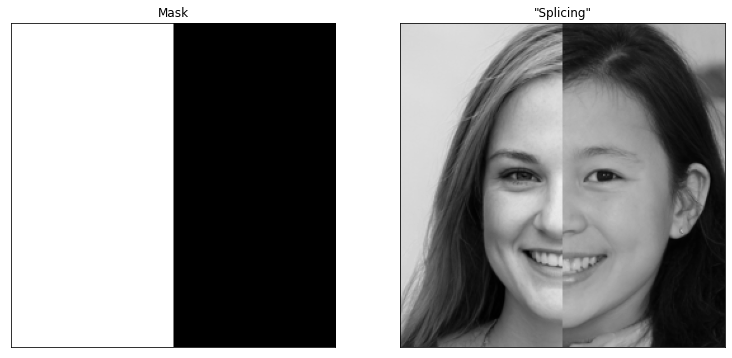

In [52]:
mask = np.hstack((np.ones((256, 128)), np.zeros((256, 128)))).astype("float64") * 255
kernel = gaussian_filter(51, sigma=1)
show_images([(mask, "Mask"),              
             (np.hstack((face1_image_grey[:,:128], face2_image_grey[:,128:])), '"Splicing"')])

Now we build the Laplacian pyramids of the two images that we wish to blend together.
This captures the details that we can add into our image at each layer.

(Warning: The Laplacian of the faces are rather spooky)

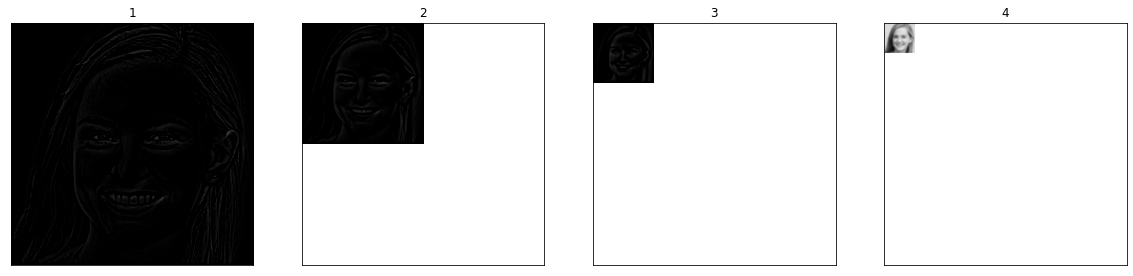

In [53]:
lapA = make_laplacian_pyramid(face1_image_grey, 4, kernel)
show_pyramids(lapA, "{}")

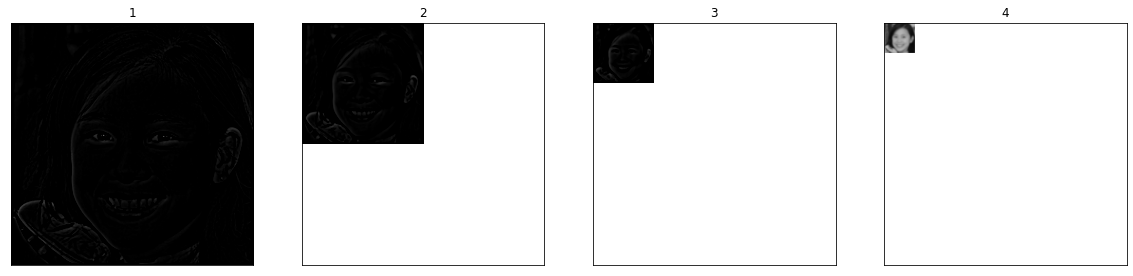

In [54]:
lapB = make_laplacian_pyramid(face2_image_grey, 4, kernel)
show_pyramids(lapB, "{}")

Rather eerie, ain't they?

Now, we obtain a Gaussian pyramid of the mask.
This blurs the harsh transition of the mask boundary at lower levels of the pyramid.
Thus, we will have more blending of the "low level" details of the 2 images, while being more selective of the higher level details at the higher levels.

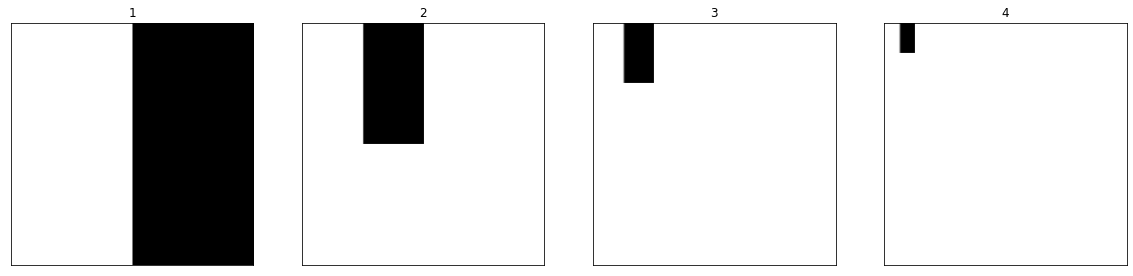

In [55]:
mask_pyramid = make_gaussian_pyramid(mask, 4, kernel)
show_pyramids(mask_pyramid, "{}", autoscale=True)

Now, using the mask pyramid, we mask over the Laplacian pyramids of both images, to obtain a new Laplacian pyramid with our blended image.

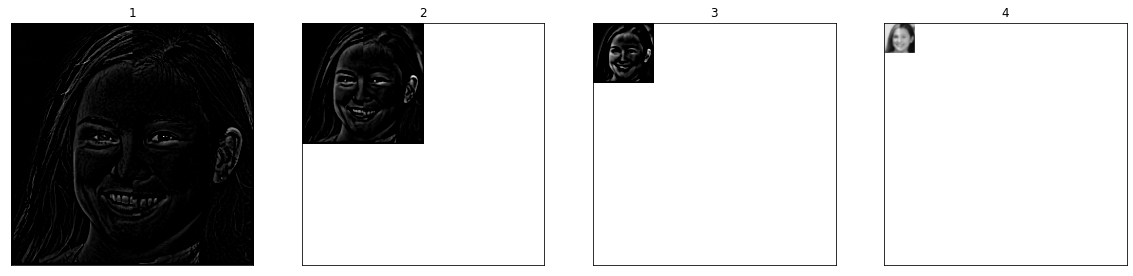

In [56]:
combined_pyramid = [A * (mask /255) + B * (1 - mask /255) for A, B, mask in zip(lapA, lapB, mask_pyramid)]
show_pyramids(combined_pyramid, "{}", autoscale=True)

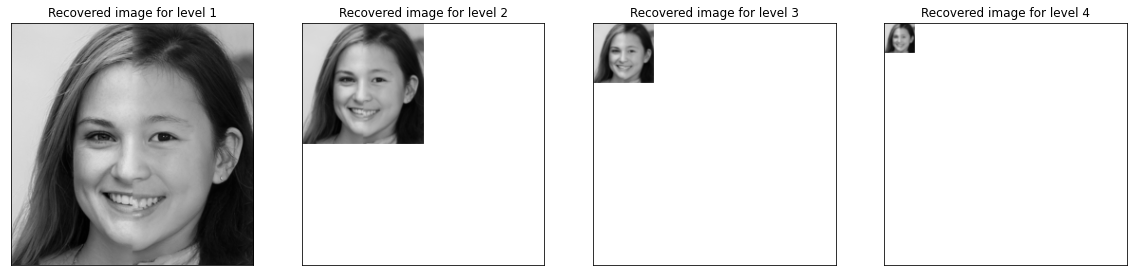

In [57]:
recovered_images = recover(combined_pyramid, kernel)
show_pyramids(recovered_images[::-1], "Recovered image for level {}")

As we can see, the harsh border is no longer present, leading to a better blending.

To recap, the workflow is:

1. Obtain the Laplacian pyramid of image A and image B
2. Obtain the Gaussian pyramid of the mask
3. Use the mask to select pixel values from image A and image B for each region in the image to obtain a blended Laplacian pyramid
4. Collapse the pyramid to obtain the desired output

### Multiscale detection
Refer to ...